In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy

In [5]:
#Construct ImageDataGenerator object:
directory = 'Covid19-dataset/train'
class_mode = 'categorical'
color_mode = 'grayscale'
target_size = (256, 256)
BATCH_SIZE = 32

print('\nLoading training data...')

training_data_generator = ImageDataGenerator(rescale = 1.0/255, zoom_range = 0.1, rotation_range = 25, width_shift_range = 0.05, height_shift_range = 0.05)

validation_data_generator = ImageDataGenerator()

training_iterator = training_data_generator.flow_from_directory(directory, class_mode = 'categorical', color_mode = 'grayscale', batch_size = BATCH_SIZE)

training_iterator.next()

print('\nLoading validation data...')

validation_iterator = validation_data_generator.flow_from_directory(directory, class_mode = 'categorical', color_mode = 'grayscale', batch_size = BATCH_SIZE)

#Print its attributes:
print('\n')
print(training_data_generator.__dict__)


Loading training data...
Found 251 images belonging to 3 classes.

Loading validation data...
Found 251 images belonging to 3 classes.


{'featurewise_center': False, 'samplewise_center': False, 'featurewise_std_normalization': False, 'samplewise_std_normalization': False, 'zca_whitening': False, 'zca_epsilon': 1e-06, 'rotation_range': 25, 'width_shift_range': 0.05, 'height_shift_range': 0.05, 'shear_range': 0.0, 'zoom_range': [0.9, 1.1], 'channel_shift_range': 0.0, 'fill_mode': 'nearest', 'cval': 0.0, 'horizontal_flip': False, 'vertical_flip': False, 'rescale': 0.00392156862745098, 'preprocessing_function': None, 'dtype': 'float32', 'interpolation_order': 1, 'data_format': 'channels_last', 'channel_axis': 3, 'row_axis': 1, 'col_axis': 2, '_validation_split': 0.0, 'mean': None, 'std': None, 'principal_components': None, 'brightness_range': None}


In [6]:
print('\nBuilding model...')
def build_model(training_data):
    #Sequential model
    model = Sequential()
    #Input layer with grayscale image shape (1)
    model.add(tf.keras.Input(shape=(256, 256, 1)))
    #Convolution hidden layers with relu activation
    #MaxPooling layers and dropout layers
    model.add(layers.Conv2D(5, 5, strides=3, activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(layers.Dropout(0.1))
    model.add(layers.Conv2D(3, 3, strides=1, activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(layers.Dropout(0.2))
    
    model.add(layers.Flatten())
    #Output layer with softmax activation
    model.add(layers.Dense(3, activation='softmax'))
    
    print('\nCompiling model...')
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=[tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.AUC()])
    
    #summarize model
    model.summary()
    return model


Building model...


In [10]:
model = build_model(training_iterator)

#early stopping
es = EarlyStopping(monitor='val_auc', mode='min', verbose=1, patience=20)


Compiling model...
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 84, 84, 5)         130       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 42, 42, 5)        0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 42, 42, 5)         0         
                                                                 
 conv2d_7 (Conv2D)           (None, 40, 40, 3)         138       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 20, 20, 3)        0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None

In [24]:
print('\nTraining model...')
EPOCHS = 10
history = model.fit(training_iterator, 
                   steps_per_epoch=training_iterator.samples/BATCH_SIZE,
                   epochs=EPOCHS,
                   validation_data=validation_iterator,
                   validation_steps=validation_iterator.samples/BATCH_SIZE,
                   callbacks=[es])


Training model...
Epoch 1/10
7/7 [==============================] - 3s 416ms/step - loss: 0.4492 - categorical_accuracy: 0.8167 - auc_3: 0.9490 - val_loss: 19.1963 - val_categorical_accuracy: 0.9124 - val_auc_3: 0.9343
Epoch 2/10
7/7 [==============================] - 3s 380ms/step - loss: 0.3901 - categorical_accuracy: 0.8486 - auc_3: 0.9614 - val_loss: 20.1886 - val_categorical_accuracy: 0.9084 - val_auc_3: 0.9313
Epoch 3/10
7/7 [==============================] - 3s 395ms/step - loss: 0.3472 - categorical_accuracy: 0.8685 - auc_3: 0.9723 - val_loss: 23.8782 - val_categorical_accuracy: 0.9163 - val_auc_3: 0.9373
Epoch 4/10
7/7 [==============================] - 3s 414ms/step - loss: 0.3901 - categorical_accuracy: 0.8327 - auc_3: 0.9584 - val_loss: 28.2819 - val_categorical_accuracy: 0.8884 - val_auc_3: 0.9246
Epoch 5/10
7/7 [==============================] - 3s 393ms/step - loss: 0.3974 - categorical_accuracy: 0.8446 - auc_3: 0.9566 - val_loss: 22.5723 - val_categorical_accuracy: 0.9

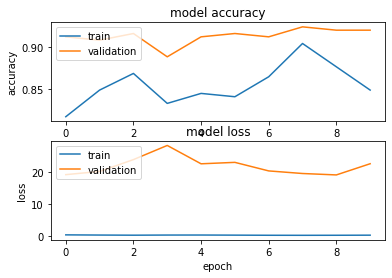

In [25]:
#plotting categorical and validation accuracy over epochs
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(history.history['categorical_accuracy'])
ax1.plot(history.history['val_categorical_accuracy'])
ax1.set_title('model accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.legend(['train', 'validation'], loc='upper left')

#plotting loss and validation loss over epochs
ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
ax2.legend(['train', 'validation'], loc='upper left')

plt.show()

In [26]:
#Create report
test_steps_per_enoch = numpy.math.ceil(validation_iterator.samples/validation_iterator.batch_size)
test_steps_per_epoch = numpy.math.ceil(validation_iterator.samples/validation_iterator.batch_size)
predictions = model.predict(validation_iterator, steps=test_steps_per_epoch)
predicted_classes = numpy.argmax(predictions, axis=1)
true_classes = validation_iterator.classes
class_labels = list(validation_iterator.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

       Covid       0.48      0.50      0.49       111
      Normal       0.29      0.26      0.27        70
   Pneumonia       0.26      0.27      0.27        70

    accuracy                           0.37       251
   macro avg       0.34      0.34      0.34       251
weighted avg       0.37      0.37      0.37       251



In [27]:
#confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
print(cm)

[[56 24 31]
 [29 18 23]
 [31 20 19]]
